# Inverse Kinematic

Inverse kinematic problem is an **inverse problem** which computes the joint parameters (usually angles $\theta$) to place the end of the kinematic chain - such as a robot arm. Inverse kinematic problems are common in computer graphics and robotics.

## Graph Utilities

In [1]:
import matplotlib.pyplot as plt

def create_plot():
    fig, ax = plt.subplots()
    reset_ax(ax)
    return fig, ax

def reset_ax(ax):
    ax.clear()
    ax.set_aspect('equal')
    ax.autoscale(enable=False)
    ax.set_xlim(-600., 600.)
    ax.set_ylim(0., 1200.)

## Problem Setup

Initializes a chain with 10 segments and no rotation

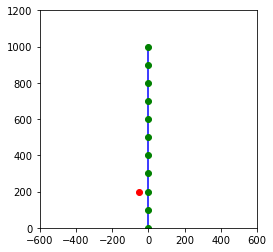

In [2]:
import numpy as np

NUM_SEGMENTS = 10
CHAIN_LENGTH = 1000.0
TARGET_POS = np.asarray([-50.0, 200.0])

chain_angles = None
chain_lengths = None

def init_chain():
    global chain_angles, chain_lengths
    chain_angles = np.zeros(NUM_SEGMENTS)
    chain_lengths = np.ones(NUM_SEGMENTS) * (CHAIN_LENGTH / NUM_SEGMENTS)
    chain_angles[0] = 90.0

def forward_kinematic():
    chain_pts = np.zeros((NUM_SEGMENTS+1, 2))
    angle = 0.0
    for i in range(NUM_SEGMENTS):
        angle += np.deg2rad(chain_angles[i])
        chain_pts[i+1][0] = np.cos(angle)
        chain_pts[i+1][1] = np.sin(angle)
        chain_pts[i+1] *= chain_lengths[i]
        chain_pts[i+1] += chain_pts[i]
    return chain_pts

def last_chain_point():
    chain_pts = forward_kinematic()
    return chain_pts[-1]

def draw_chain(fig, ax, chain_pts):
    # TODO - add a plot legend 
    # draw chain
    x, y = zip(*chain_pts)  
    ax.plot(x, y, "b-", markersize=2) # draw blue segments
    ax.plot(x, y, 'go') # draw green points
    ax.plot(TARGET_POS[0], TARGET_POS[1], 'ro') # draw red target

init_chain()
fig, ax = create_plot()
draw_chain(fig, ax, forward_kinematic())

## Jacobian Computation

Layout of the partial differential matrix of size(m x n)
'm' is the number of DOF for the end effector (only translate XY)
'n' is the number of joints multiplied by the number of joint DOF
    joint0      joint1     joint2   
    angle0      angle1     angle2
x :  dx/da0     dx/da1     dx/da2
y :  dy/da0     dy/da1     dy/da2 

In [3]:
def compute_jacobian():
    chain_pts = forward_kinematic()
    J = np.zeros(shape=(2,NUM_SEGMENTS))
    for i in range(NUM_SEGMENTS):
        vec = chain_pts[-1] -  chain_pts[i]
        # x = norm(vec) * cos(angle) and x' = norm(vec) * -sin(angle)
        # y = norm(vec) * sin(angle) and y' = norm(vec) * cos(angle)
        # hence x' = y * -1 and y' = x
        J[0, i] = vec[1] * -1 * np.sin(np.deg2rad(1.0))
        J[1, i] = vec[0] * np.sin(np.deg2rad(1.0))

    return np.matrix(J)

## Damped Least-Squared

Damped Least-Squared (also know **Levenberg–Marquardt**) algorithm solves non-linear least square problems.
TODO - add the equation

We are using the **Tikhonov regularization** has regularization term

In [4]:
REGULARIZATION_TERM = 0.1

def damped_least_square(J):
    damping_matrix_constant = np.identity(2) * REGULARIZATION_TERM
    invJ = J * J.transpose()
    invJ += damping_matrix_constant
    invJ = np.linalg.inv(invJ)
    return(J.transpose() * invJ)

## Analysis

TODO - Show the singular values and condition number plot from different regularization term

The **singular values** to indicate whether the matrix inversion is stable<br>
SVD decompose the matrix into U.E.Vt<br>
where U and V are othogonal and E is the diagonal matrix containing singular values<br>
hence its inverse is V.1/E.Ut<br>
Large singular values makes the matrix inverse going to infinity

In [5]:
def singluar_values(matrix):
    singular_values = np.linalg.svd(matrix, compute_uv = False)
    return singular_values

The **condition number** measures how close a matrix is to being singular: a matrix with a high condition number is nearly singular, whereas a matrix with a low condition number is far from singular.

In [6]:
def condition_number(matrix):
    # TODO
    pass

## Solver

### IK Step

In [7]:
def ik_step(max_step_size):
    vec = np.reshape(TARGET_POS - last_chain_point(), (2,1))
    vec_norm = np.linalg.norm(vec)
    if (vec_norm > max_step_size):
        vec /= vec_norm
        vec *= max_step_size

    J = compute_jacobian()
    pseudo_inverse = damped_least_square(J)

    # Debugging
    # singluar_values(pseudo_inverse)
    # condition_number(pseudo_inverse)
    
    delta_angles = np.dot(pseudo_inverse, vec)
    for i in range(NUM_SEGMENTS):
        chain_angles[i] += delta_angles[i]

### Main Loop

In [8]:
%matplotlib inline

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

MAX_ITERATIONS = 100
MAX_STEP_SIZE = 100
THRESHOLD = 1.0 # acceptable from last

# Reinitialize the chain
init_chain()

# Function to determinate if a point is close to the target
close_to_target = lambda pos : (np.linalg.norm(TARGET_POS - pos) < THRESHOLD)

# Solver iteration
iteration = 0
iteration_results = []
while iteration < MAX_ITERATIONS and not close_to_target(last_chain_point()):
    if (iteration > 0):
        ik_step(MAX_STEP_SIZE)

    iteration_results.append(forward_kinematic())
    iteration += 1

# Create an animation from results
fig, ax = create_plot()
def update_figure(frame_num):
    reset_ax(ax)
    # TODO - display iteration number
    draw_chain(fig, ax, iteration_results[frame_num])
    
plt.close()
num_frames = len(iteration_results)
anim = FuncAnimation(fig, update_figure, frames=num_frames, interval=40)
HTML(anim.to_jshtml())